# Robust Varibad Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cross_entropy_sampler as cem
import general_utils as utils
import analysis

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

C:\Users\idogr\AppData\Local\Temp\ipykernel_40728\867683384.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Configuration

In [2]:
ENV_NAME = 'HumanoidMass-v0'
TITLE = ENV_NAME[:-3]
ENV_SHORT = 'humm'
TASKS = ['mass']
TASK_DIM = len(TASKS)
METHODS = ('varibad', 'cembad', 'cvrbad')
NM_MAP = dict(varibad='VariBAD', cvrbad='CVaR-ML', cembad='RoML')
SEEDS = list(range(30))
ALPHA = 0.05

### The CEM

In [3]:
TRANSFORMATION = lambda x: 2 ** (2*(x-0.5))
YLIM = (0, 2)
SMOOTH = 20
CEM_SEED = 0

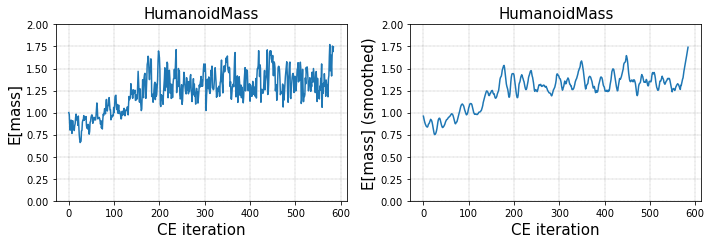

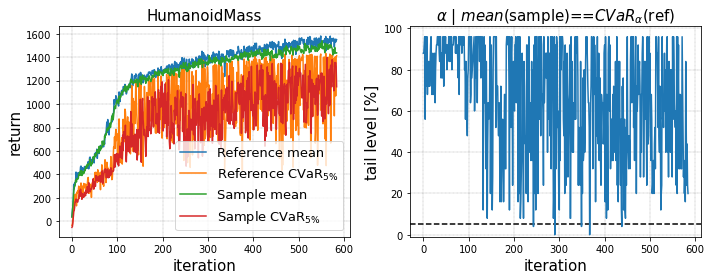

In [4]:
ce, c1, c2, axs1, axs2 = analysis.cem_analysis(
    ENV_NAME, TASK_DIM, TRANSFORMATION, YLIM, SMOOTH, title=TITLE, tasks=TASKS, seed=CEM_SEED)
plt.sca(axs1[0])
plt.savefig(f'outputs/{ENV_SHORT}_sample_dist.png', bbox_inches='tight', dpi=300)
plt.sca(axs2[0])
plt.savefig(f'outputs/{ENV_SHORT}_cem.png', bbox_inches='tight', dpi=300)

## Test results

In [3]:
%%time
rr, rra, rrm, rrc, rr0, rra0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'best_mean' if nm=='varibad' else 'best_cvar', nm_map=NM_MAP)
rr

Test tasks: 1008
CPU times: total: 1min 28s
Wall time: 1min 34s


,ep,ret,task0,method,seed
0,0,1720.766479,0.944335,VariBAD,0
1,1,1719.915527,0.944335,VariBAD,0
2,0,1513.906616,1.319355,VariBAD,0
3,1,1489.883179,1.319355,VariBAD,0
4,0,1758.607422,0.900947,VariBAD,0
...,...,...,...,...,...
181435,1,629.583313,1.014950,CVaR-ML,29
181436,0,619.692383,0.516780,CVaR-ML,29
181437,1,592.350281,0.516780,CVaR-ML,29
181438,0,495.195801,0.743323,CVaR-ML,29


Test returns vs. task - over all seeds aggregated:
CPU times: total: 1.77 s
Wall time: 1.88 s


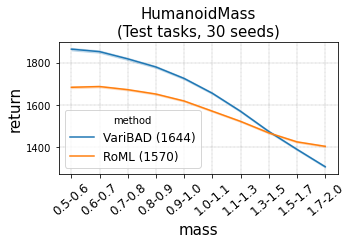

In [18]:
%%time
axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_x_ndigits=1)
plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

In [7]:
# axs = analysis.summarize_test(rra0, rr0, ALPHA)

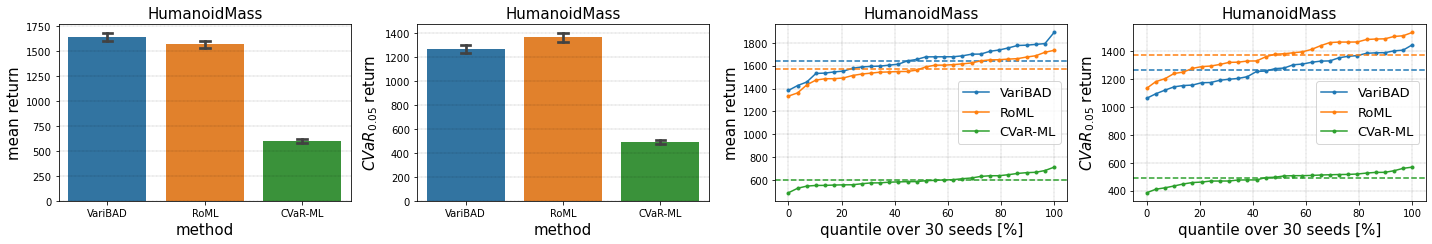

In [8]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE, barplot=True)

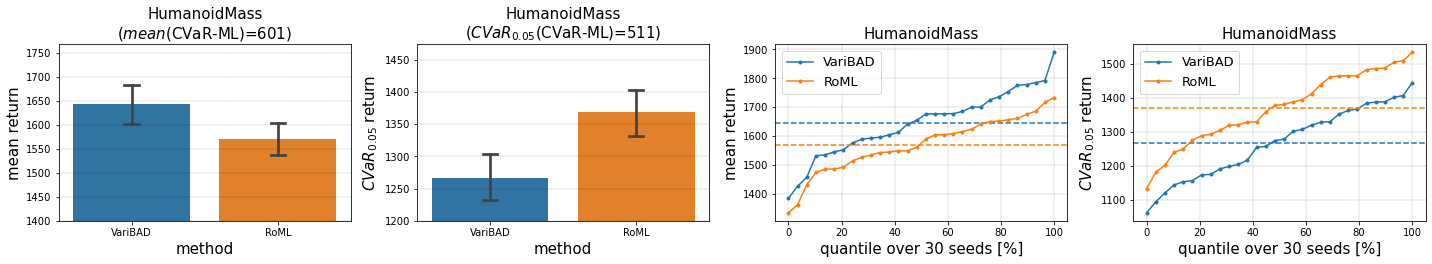

In [9]:
axs = analysis.summarize_test_over_seeds(rrm[rrm.method!='CVaR-ML'], rrc[rrc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_title(f'{TITLE}\n($mean$(CVaR-ML)={rrm.ret[rrm.method=="CVaR-ML"].mean():.0f})', fontsize=15)
axs[0].set_ylim((1400, None))
axs[1].set_title(f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={analysis.get_cvar_fun(ALPHA)(rrm.ret[rrm.method=="CVaR-ML"]):.0f})', fontsize=15)
axs[1].set_ylim((1200, None))
plt.savefig(f'outputs/{ENV_SHORT}_summary.png', bbox_inches='tight', dpi=300)

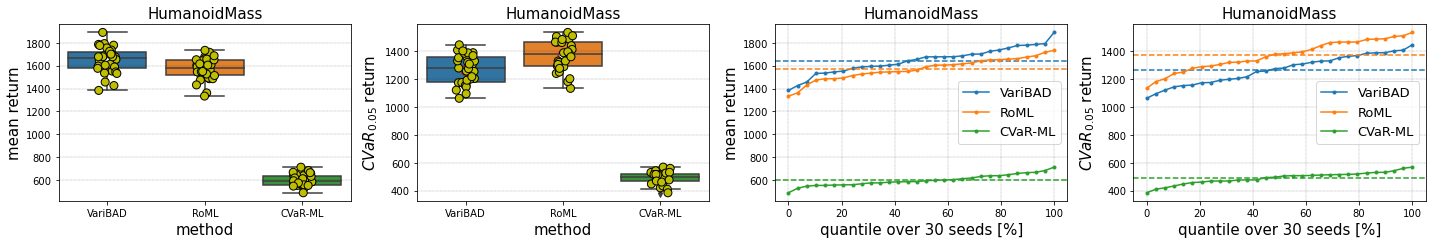

In [10]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE)

### Final models test (not best over validation)

In [3]:
%%time
bb, bba, bbm, bbc, bb0, bba0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'final', nm_map=NM_MAP)

Test tasks: 1008
CPU times: total: 49.8 s
Wall time: 1min


Test tasks: 1008
Test returns vs. task - over all seeds aggregated:
CPU times: total: 1min 41s
Wall time: 1min 48s


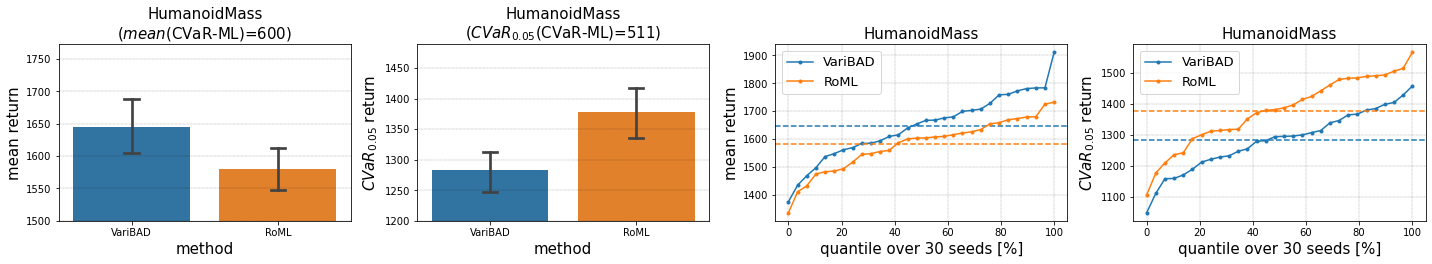

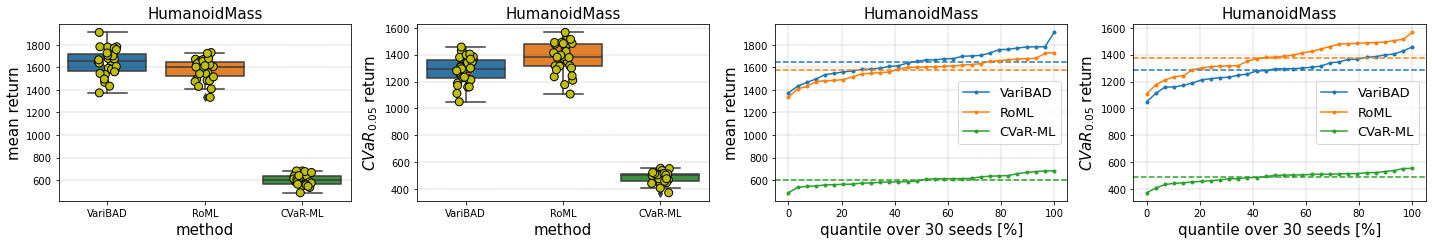

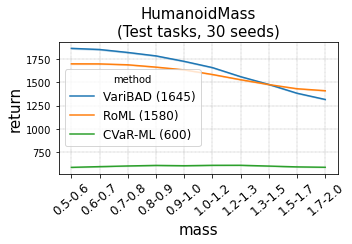

In [4]:
axs = analysis.summarize_test_over_seeds(bbm[bbm.method!='CVaR-ML'], bbc[bbc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_ylim((1500, None))
axs[1].set_ylim((1200, None))

axs = analysis.summarize_test_over_seeds(bbm, bbc, ALPHA, TITLE)
axs2 = analysis.show_test_vs_tasks(bba, bba0, TITLE, TASKS)

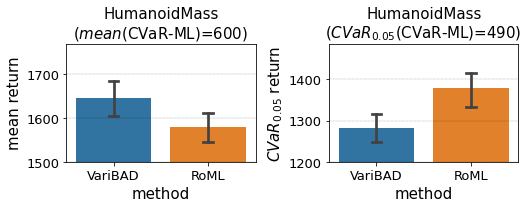

In [5]:
axs = utils.Axes(2, 2, (3.7,3.0), fontsize=15)
a = 0

sns.barplot(data=bbm[bbm.method!='CVaR-ML'], x='method', y='ret', ci=95, capsize=0.1, ax=axs[a])
axs[a].set_ylim((1500, None))
axs[a].tick_params(axis='both', which='major', labelsize=13)
axs.labs(a, 'method', f'mean return', f'{TITLE}\n($mean$(CVaR-ML)={bbm.ret[bbm.method=="CVaR-ML"].mean():.0f})')
a += 1

sns.barplot(data=bbc[bbc.method!='CVaR-ML'], x='method', y='ret', ci=95, capsize=0.1, ax=axs[a])
axs[a].set_ylim((1200, None))
axs[a].tick_params(axis='both', which='major', labelsize=13)
axs.labs(a, 'method', f'$CVaR_{{{ALPHA}}}$ return', f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={bbc.ret[bbc.method=="CVaR-ML"].mean():.0f})')
a += 1

plt.tight_layout()
plt.savefig(f'outputs/{ENV_SHORT}_f_summary.png', bbox_inches='tight', dpi=300)

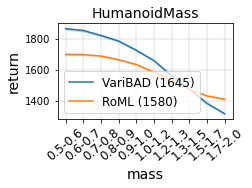

In [6]:
# axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_x_ndigits=1)

task_dim = analysis.get_task_dim(bba)
axs = utils.Axes(task_dim, task_dim, (3.6,2.5), fontsize=14)
a = 0
for i in range(task_dim):
    utils.compare_quantiles(bba[bba.method!='CVaR-ML'], f'task{i:d}', 'ret', 'method',
                            xbins=11, lab_rotation=40, axs=axs, a0=a, ci=95)
    axs.labs(a, TASKS[i], 'return', TITLE)
    axs[a].legend(fontsize=12)
    a += 1

plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

## Validation results

In [12]:
%%time
dd, dda, ddm, ddc, dd0, dda0, task_dim = analysis.load_train_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, nm_map=NM_MAP)
dd

humm_varibad_0__24_10_12_18_22
humm_varibad_1__24_10_23_12_12
humm_varibad_2__25_10_10_12_00
humm_varibad_3__25_10_21_07_02
humm_varibad_4__27_10_20_49_30
humm_varibad_5__28_10_08_30_32
humm_varibad_6__28_10_20_10_02
humm_varibad_7__29_10_07_51_56
humm_varibad_8__29_10_19_48_09
humm_varibad_9__30_10_06_28_39
humm_varibad_10__14_12_20_49_24
humm_varibad_11__09_12_17_15_53
humm_varibad_12__10_12_04_39_06
humm_varibad_13__10_12_15_58_14
humm_varibad_14__11_12_03_19_48
humm_varibad_15__11_12_14_40_44
humm_varibad_16__12_12_02_02_00
humm_varibad_17__12_12_13_27_27
humm_varibad_18__13_12_00_47_45
humm_varibad_19__13_12_11_48_43
humm_varibad_20__13_12_22_36_33
humm_varibad_21__14_12_09_27_58
humm_varibad_22__20_12_13_13_01
humm_varibad_23__21_12_11_02_17
humm_varibad_24__21_12_11_02_20
humm_varibad_25__21_12_11_02_17
humm_varibad_26__21_12_11_02_17
humm_varibad_27__21_12_11_04_25
humm_varibad_28__21_12_11_04_30
humm_varibad_29__21_12_11_04_27
humm_cembad_0__24_10_12_18_26
humm_cembad_1__24_10

,iter,task_id,ep,ret,task0,method,seed
0,-1,0,0,9.125528,0.731751,VariBAD,0
1,-1,0,1,62.050671,0.731751,VariBAD,0
2,-1,1,0,73.681656,0.785910,VariBAD,0
3,-1,1,1,2.708477,0.785910,VariBAD,0
4,-1,2,0,87.309868,1.331609,VariBAD,0
...,...,...,...,...,...,...,...
351931,2324,29,1,620.610229,0.611233,CVaR-ML,29
351932,2324,30,0,515.132751,1.339681,CVaR-ML,29
351933,2324,30,1,590.896362,1.339681,CVaR-ML,29
351934,2324,31,0,524.409729,0.962829,CVaR-ML,29


In [13]:
# axs = analysis.show_task_distribution(dda0, rra0, TASKS)

In [14]:
# %%time
# axs = analysis.show_validation_vs_tasks(dda, TASKS)

In [15]:
# %%time
# axs = analysis.show_validation_results(dda0, ALPHA)

CPU times: total: 13 s
Wall time: 13.7 s


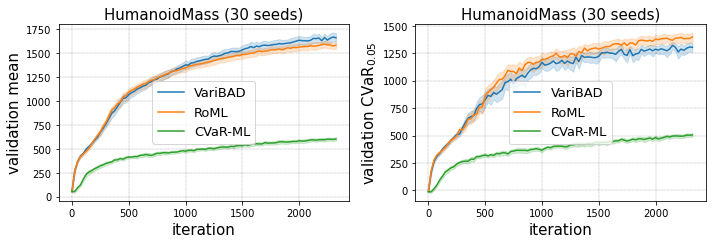

In [20]:
%%time
axs = analysis.show_validation_results_over_seeds(ddm, ddc, ALPHA, TITLE, ci=95, axsize=(5,3.5))
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
plt.savefig(f'outputs/{ENV_SHORT}_valid.png', bbox_inches='tight', dpi=300)